# Optimal Portfolio
This notebook construct 3 different optimal portfolios. The maximum sharpe-ratio portfolio (*simple risk adjusted return*), the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*) and the minimum variance portfolio.

\begin{align}
    \text{Sharpe Ratio}&=\frac{R_{p}-R_{f}}{\sigma_{p}}\\
    \text{Calmar Ratio}&=\frac{R_{p}-R_{f}}{\text{Maximum Drawdown}}
\end{align}
where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate, $\sigma_{p}$ denotes the standard deviation ($\approx$*risk*) of the portfolio and maximum drawdown is measured as the pct.-change from trough to peak, i.e. peak-value minus trough-value divided by peak-value.




In [1]:
############## Loading relevant packages ##############
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# local module
import pftools
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [2]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE']

# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','C:/Users/olufk/OneDrive/Documents/GitHub/PortfolioDesign/PortfolioDesign/OptimalPF/Data_Investing_com/')

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['fortum.he', 'danske.co', 'saf.pa', 'wm']

# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
df, rdf, cdf = pftools.df_generator(tickers,'yahoo',start,end)

In [ ]:
df

## Describing each tickers
Now that data is loaded, it's time to get an idea of the characteristics of the tickers

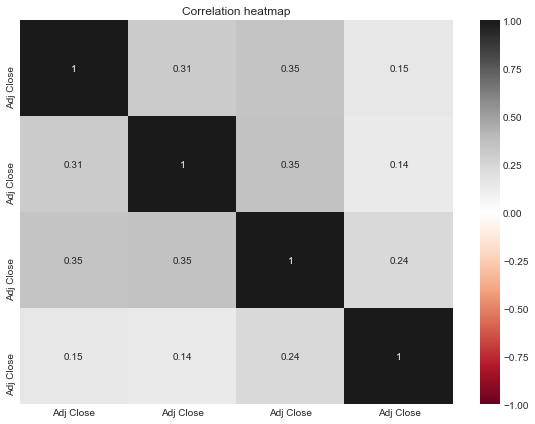

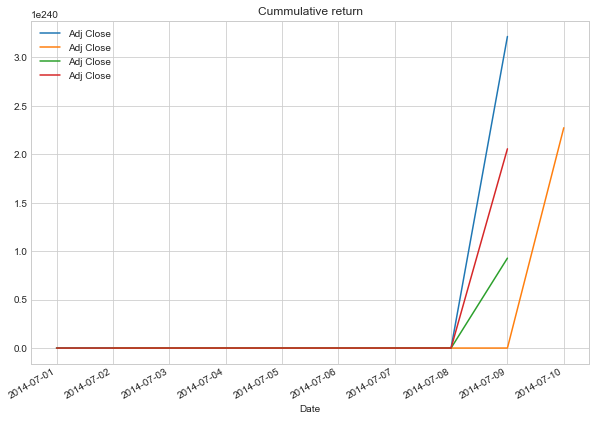

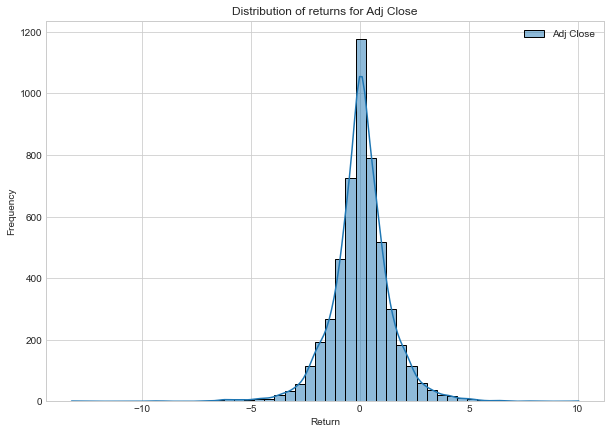

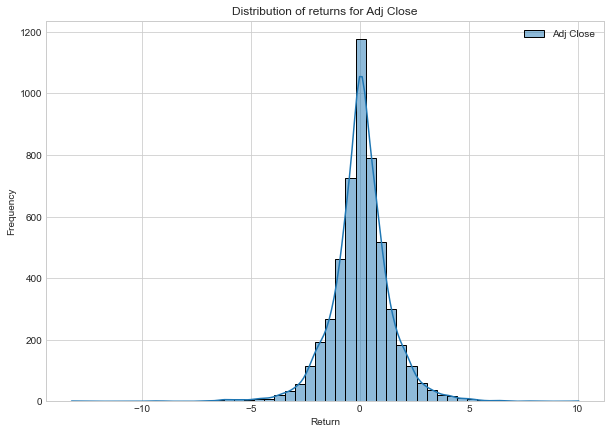

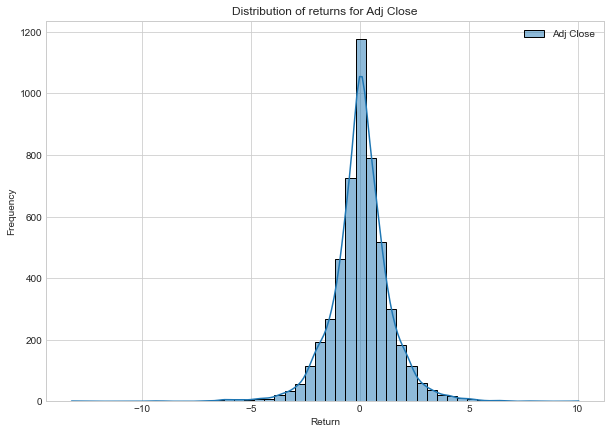

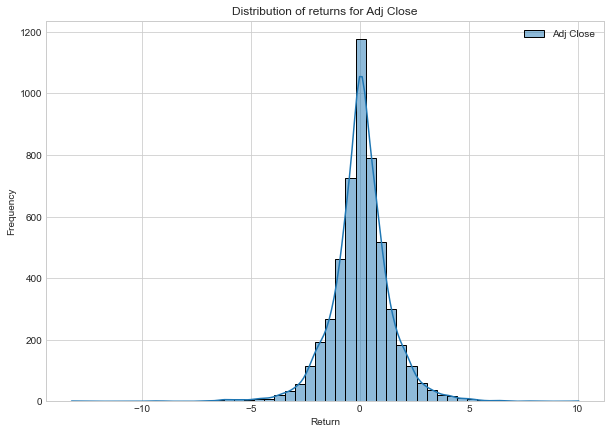

KeyError: Timestamp('2019-06-28 00:00:00')

In [9]:
pftools.desc_ticks(df,rdf,cdf)